<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Part II - 2 <br><br><br>
  Machine Translation
  </div> 

  <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. <font color=red>**Machine Translation**</font>


### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | |
|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 



# Packages

In [1]:
import sys
import warnings
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.3.1
DL device : cuda


In [2]:
path_to_NLP = 'C:\\Users\\Jb\\Desktop\\NLP'

In [3]:
sys.path.append(path_to_NLP + '\\libDL4NLP')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.<br> Le corpus est donc une fois importé sous le forme :<br>

- corpus = [text]<br>
- text   = [word]<br>
- word   = str<br>

In [4]:
# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
 
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    s = re.sub("\(", r" ( ", s)
    s = re.sub("\)", r" ) ", s)
    s = re.sub(r"\.", r" . ", s)
    s = re.sub(r",", r" , ", s)
    s = re.sub(r"!", r" ! ", s)
    s = re.sub(r":", r" : ", s)
    s = re.sub(r"-", r" - ", s)
    s = re.sub(r"'", r" ' ", s)
    s = re.sub(r";", r" ; ", s)
    s = re.sub(r' +', r' ', s).strip()
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(path, limit = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    def cleanS(s):
        cleans = normalizeString(s)
        cleans = cleans.replace('?', ' ? ').strip()
        return cleans
    
    dialogues = []
    dialogues_import = open(path, encoding='utf-8').read().strip().split('\n\n')
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [cleanS(s) for s in l.split('\t')]
                dialogue.append(pair)
            elif len(l.split('\t')) == 3 :
                pair = [cleanS(s) for s in l.split('\t')[:2]]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limit is not None and i == limit -1 : break
    return dialogues


def getUniqueQAs(dialogues) :
    uniq = []
    for qa in dialogues :
        if qa not in uniq : uniq.append(qa)
    return uniq



#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar

In [5]:
motsVar    = motVar(path_to_NLP + '\\data\\M2DS\\M2DS_2019_07\\chatbot-M2-DS-Variables.txt')
dialogues  = importDialogues(path_to_NLP + '\\data\\M2DS\\M2DS_2019_10\\ChatbotDS_P_Train.tsv')
dialogues_tst = importDialogues(path_to_NLP + '\\data\\M2DS\\M2DS_2019_10\\ChatbotDS_P_Test.tsv')

In [6]:
qa_trn = [qa for dialogue in dialogues for qa in dialogue] # getUniqueQAs(
qa_tst = [qa for dialogue in dialogues_tst for qa in dialogue] # getUniqueQAs(

print(len(qa_trn), len(qa_tst))

200224 20561


In [7]:
for qa in dialogues[0] : print(qa[0], '\t', qa[1])

il vaut mieux suivre quel parcours  ? 	 les deux parcours sont equivalents , c ' est a vous de faire un choix .
quand est ce que commence les cours  ? 	 la rentree est le daterentree
comment je prend contact avec la scolarite  ? 	 les contacts de la scolarite sont accessibles sur : sitescolarite
est ce que il y a des cours en anglais  ? 	 plusieurs supports de cours sont en anglais
tous les cours sont obligatoires  ? 	 tous les cours sont obligatoires , il n ' existe pas d ' options .
merci pour les renseignements 	 je vous en prie
peux tu m ' aider  ? 	 je suis la pour vous renseigner sur le master 2 data science .
le cours de data visualisation est - il en ligne  ? 	 vous devriez prendre contact avec l ' enseignant de l ' ue et lui demander
j ' ai envie de faire de la data science 	 alors vous devriez songer a candidater a ce master !
il y a des livres a lire en statistique  ? 	 vous devriez prendre contact avec l ' enseignant de l ' ue et lui demander
il y a combien de candidats  ? 

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

All details on Word Embedding modules and their pre-training are found in **Part I - 1**. We consider here a FastText model trained following the Skip-Gram training objective.

In [8]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [9]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

**Option 1** : Load pretrained

In [ ]:
# load
#word2vec_in  = torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_in_M2DS.pt')
#word2vec_out = torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_out_M2DS.pt')

**Option 2** : Train new model

In [10]:
corpus_in  = [['SOS'] + [w for w in qa[0].split(' ')] + ['EOS'] for qa in qa_trn]
corpus_out = [['SOS'] + [w for w in qa[1].split(' ')] + ['EOS'] for qa in qa_trn]

In [53]:
def prepareWord2vec(corpus, epochs) :
    fastText_word2vec = FastText(size = 75, 
                                 window = 5, 
                                 min_count = 1, 
                                 negative = 20,
                                 sg = 1)
    fastText_word2vec.build_vocab(corpus)
    print(len(fastText_word2vec.wv.vocab))
    fastText_word2vec.train(sentences = corpus, 
                            epochs = epochs,
                            total_examples = fastText_word2vec.corpus_count)
    word2vec = Word2VecConnector(fastText_word2vec)
    return word2vec

In [54]:
word2vec_in  = prepareWord2vec(corpus_in, epochs = 20)
word2vec_out = prepareWord2vec(corpus_out, epochs = 20)

782
896


In [55]:
word2vec_in.word2vec.most_similar('bonjou')

[('bonjour', 0.9804752469062805),
 ('mal', 0.8117103576660156),
 ('bien', 0.6764619946479797),
 ('principal', 0.672505259513855),
 ('principalement', 0.5881912112236023),
 ('english', 0.578591525554657),
 ('handle', 0.5670300722122192),
 ('coucou', 0.5658980011940002),
 ('ok', 0.5612411499023438),
 ('speak', 0.5596966743469238)]

In [56]:
word2vec_out.word2vec.most_similar('bonjou')

[('bonjour', 0.968519926071167),
 ('accord', 0.7767391204833984),
 ('comment', 0.6192842721939087),
 ('aider', 0.5911822319030762),
 ('accordez', 0.5513397455215454),
 ('vais', 0.4964368939399719),
 ('puis', 0.4900757372379303),
 ('gardez', 0.48046615719795227),
 ('merci', 0.4791063368320465),
 ('test', 0.47400200366973877)]

In [58]:
# save
#torch.save(word2vec_in, path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_in_M2DS.pt')
#torch.save(word2vec_out, path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_out_M2DS.pt')

### 1.2 Contextualization module

[Back to top](#plan)

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [15]:
from libDL4NLP.modules import RecurrentEncoder

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

We use here a classical Attention Module :

In [16]:
from libDL4NLP.modules import Attention

### 1.4 Decoder module

[Back to top](#plan)

<a id="decoder"></a>

#### 1.4.1 Classical Decoder Module

In [17]:
#from libDL4NLP.modules import Decoder

In [17]:
class Decoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, hidden_dim, 
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(Decoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        self.gru = nn.GRU(word2vec.output_dim, 
                          hidden_dim, 
                          n_layers, 
                          dropout = dropout, 
                          batch_first = True)
        self.out = nn.Linear(hidden_dim, word2vec.lang.n_words)
        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)
        
    def generateWord(self, hidden, embeddings, word_index):
        # update hidden state
        embedding = self.word2vec.embedding(word_index) # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        # generate next word
        log_prob = self.out(hidden[-1])                 # size (batch_size, lang_size)
        log_prob = self.act(log_prob, dim = 1)          # size (batch_size, lang_size)
        return log_prob, hidden
    
    def forward(self, hidden, embeddings = None, device = None) :
        answer = []
        EOS_token  = self.word2vec.lang.getIndex('EOS')
        word = self.word2vec.lang.getIndex('SOS')
        word = Variable(torch.LongTensor([[word]])) # size (1)
        hidden = hidden[-self.n_layers:]
        for t in range(self.bound) :
            # compute next word
            if device is not None : word = word.to(device) # size (1)
            log_prob, hidden = self.generateWord(hidden, embeddings, word)
            word = log_prob.topk(1, dim = 1)[1].view(1, 1)
            # add to output
            if word.item() == EOS_token : break
            else : answer.append(word.item())
        return answer

#### 1.4.2 Attention Decoder Module

In [19]:
#from libDL4NLP.modules import AttnDecoder

In [18]:
class AttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attention_dim, hidden_dim,
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(AttnDecoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        self.gru = nn.GRU(word2vec.output_dim, 
                          hidden_dim, 
                          n_layers, 
                          dropout = dropout, 
                          batch_first = True)
        self.attn = Attention(attention_dim, hidden_dim, dropout = dropout)
        self.out = nn.Linear(attention_dim + hidden_dim, word2vec.lang.n_words)
        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)
        
    def generateWord(self, hidden, embeddings, word_index):
        # update hidden state
        embedding = self.word2vec.embedding(word_index) # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        # merge with attention
        query = hidden[-1].unsqueeze(1)                 # size (batch_size, 1, embedding_dim)
        attn, weights = self.attn(embeddings, query)    # size (batch_size, 1, embedding_dim)
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                     # size (batch_size, embedding_dim + hidden_dim)
        # generate next word
        log_prob = self.out(merge)                      # size (batch_size, lang_size)
        log_prob = self.act(log_prob, dim = 1)          # size (batch_size, lang_size)
        return log_prob, hidden, weights
    
    def forward(self, hidden, embeddings, device = None) :
        answer  = []
        EOS_token  = self.word2vec.lang.getIndex('EOS')
        word = self.word2vec.lang.getIndex('SOS')
        word = Variable(torch.LongTensor([[word]])) # size (1)
        hidden = hidden[-self.n_layers:]
        for t in range(self.bound) :
            # compute next word
            if device is not None : word = word.to(device) # size (1)
            log_prob, hidden, atn = self.generateWord(hidden, embeddings, word)
            word = log_prob.topk(1, dim = 1)[1].view(1, 1)
            # add to output
            if word.item() == EOS_token : break
            else : answer.append(word.item())
            # cumulate attention weights
            if t == 0 : weights = atn
            else      : weights = torch.cat((weights, atn), dim = 1) # size(1, output_length, input_length)
        return answer, weights

#### Visualisation of attention

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [430]:
from libDL4NLP.utils import heatmap, annotate_heatmap

In [19]:

# single attention head over a sequence of words
def heatmap(data, row_labels, col_labels, ax = None, cbar_kw = {}, cbarlabel = "", **kwargs):
    if not ax: ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im

def annotate_heatmap(im, data = None, valfmt = "{x:.2f}", textcolors = ["black", "white"], threshold = None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

<a id="model"></a>

# 2 Machine Translation Model

[Back to top](#plan)


In [96]:
class EncoderDecoder(nn.Module) :
    def __init__(self, device, tokenizer, word2vec_in, word2vec_out, 
                 hidden_dim_in = 50,
                 hidden_dim_out = 50,
                 n_layers_in = 1,
                 n_layers_out = 1,
                 bound = 25,
                 dropout = 0,
                 decoder_warm_start = True,
                 decoder_attention = True,
                 optimizer = optim.SGD
                 ):
        super(EncoderDecoder, self).__init__()
        #relevant quantities
        self.decoder_warm_start = decoder_warm_start
        
        # modules
        self.tokenizer    = tokenizer
        self.word2vec_in  = word2vec_in
        self.word2vec_out = word2vec_out
        self.context      = RecurrentEncoder(word2vec_in.output_dim, hidden_dim_in, n_layers_in, dropout, bidirectional = True)
        if decoder_attention : self.decoder = AttnDecoder(word2vec_out, hidden_dim_in, hidden_dim_out, n_layers_out, dropout, bound)
        else :                 self.decoder = Decoder(word2vec_out, hidden_dim_out, n_layers_out, dropout, bound)
        
        # optimizer
        self.ignore_index_in  = self.word2vec_in.lang.getIndex('PADDING_WORD')
        self.ignore_index_out = self.word2vec_out.lang.getIndex('PADDING_WORD')
        self.criterion = nn.NLLLoss(size_average = False, ignore_index = self.ignore_index_out)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    def showAttention(self, words_in, words_out, attn) :
        attn = np.array(attn[0].transpose(0, 1).data.cpu().numpy()) # size (input_length, output_length)
        fig, ax  = plt.subplots()
        im       = heatmap(attn,  words_in, words_out, ax=ax, cmap="YlGn", cbarlabel="harvest [t/year]")
        texts    = annotate_heatmap(im, valfmt="{x:.2f}")
        fig.tight_layout()
        plt.show()
        return
    
    def forward(self, sentence, show_attention = False):
        # encode sentence
        words = self.tokenizer(sentence)
        words = [w for w in words if self.word2vec_in.lang.getIndex(w) is not None]
        indices = [self.word2vec_in.lang.getIndex(w) for w in words]
        embeddings = Variable(torch.LongTensor([indices])).to(self.device)
        embeddings = self.word2vec_in.embedding(embeddings)
        #embeddings = self.word2vec_in(words, self.device)
        embeddings, hidden  = self.context(embeddings)
        # prepare for decoding
        if self.decoder_warm_start :
            if self.context.bidirectional :
                hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
            hidden = hidden[-self.decoder.n_layers:]
        else : hidden = None    
        ## compute answer
        indices, atn = self.decoder(hidden, embeddings, self.device)
        words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
        answer = ' '.join(words_out)
        if show_attention : self.showAttention(words, words_out, atn)
        return answer

    def generatePackedSentences(self, sentences, batch_size = 32) : 
        sentences.sort(key = lambda s: len(s[1]), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            # prepare input and target pack
            pack = sentences[i:i + batch_size]
            pack.sort(key = lambda s: len(self.tokenizer(s[0])), reverse = True)
            pack0 = [[self.word2vec_in.lang.getIndex(w) for w in self.tokenizer(qa[0])] for qa in pack]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            pack1 = [[self.word2vec_out.lang.getIndex(w) for w in self.tokenizer(qa[1]) + ['EOS']] for qa in pack]
            pack1 = [[w for w in words if w is not None] for words in pack1]
            lengths0 = torch.tensor([len(p) for p in pack0])           # size (batch_size) 
            lengths1 = torch.tensor([len(p) for p in pack1])           # size (batch_size) 
            # padd packs
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.ignore_index_in))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1)) # size (batch_size, max_length0) 
            pack1 = list(itertools.zip_longest(*pack1, fillvalue = self.ignore_index_out))
            pack1 = Variable(torch.LongTensor(pack1))       # WARNING : size (max_length1, batch_size) 
            packed_data.append([pack0, lengths0, pack1, lengths1])
        return packed_data
    
    def compute_accuracy(self, sentences, batch_size = 32) :
        batches = self.generatePackedSentences(sentences, batch_size)
        score = 0
        for batch in batches :
            input, input_l, target, target_l = batch
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            answers = torch.zeros(target.size())
            word_index = self.word2vec_out.lang.getIndex('SOS')
            word_index = Variable(torch.LongTensor([word_index])) # size (1)
            word_index = word_index.expand(target.size(1))        # size (batch_size)
            for t in range(target.size(0)) :
                # compute word probs
                log_prob, hidden, atn = self.decoder.generateWord(hidden, embeddings, word_index.unsqueeze(1).to(self.device))
                word_index = log_prob.topk(1, dim = 1)[1].view(-1) # size (batch_size)
                answers[t] = word_index
            # update score
            score += sum([sum(answers[i, :l].data == target[i, :l].data) == l for i, l in enumerate(target_l.data.cpu().tolist())]).item()
        return score * 100 / len(sentences)
    
    def fit(self, batches, iters = None, epochs = None, tf_ratio = 0, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeSuccess(log_probs, targets) :
            success = sum([self.ignore_index_out != targets[i].item() == log_probs[i].topk(1)[1].item() \
                           for i in range(targets.size(0))])
            return success
        
        def computeLogProbs(batch, tf_ratio = 0, compute_accuracy = True) :
            loss = 0
            success = 0
            forcing = (random.random() < tf_ratio)
            input, input_l, target, target_l = batch
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden  = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            word_index = self.word2vec_out.lang.getIndex('SOS')
            word_index = Variable(torch.LongTensor([word_index])) # size (1)
            word_index = word_index.expand(target.size(1))        # size (batch_size)
            for t in range(target.size(0)) :
                # compute word probs
                log_prob, hidden, atn = self.decoder.generateWord(hidden, embeddings, word_index.unsqueeze(1).to(self.device))
                # compute loss
                loss += self.criterion(log_prob, target[t])
                if compute_accuracy : success += computeSuccess(log_prob, target[t])
                # apply teacher forcing
                if forcing : word_index = target[t]                             # size (batch_size) 
                else       : word_index = log_prob.topk(1, dim = 1)[1].view(-1) # size (batch_size)
            return loss, success       

        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, tf_ratio = 0, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update."""
            optimizer.zero_grad()
            self.zero_grad()
            total = torch.sum(batch[-1]).item()
            loss, success = computeLogProbs(batch, tf_ratio, compute_accuracy)
            loss.backward()
            optimizer.step()
            return float(loss.item() / total), float(success * 100 / total)
        
        # --- main ---
        self.train()
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

#### Training

In [61]:
max([len(qa[1].split(' ')) for qa in qa_trn])

69

In [97]:
chatbot = EncoderDecoder(device = torch.device("cpu"),
                         tokenizer = lambda s : normalizeString(s).split(' '),
                         word2vec_in = word2vec_in,
                         word2vec_out = word2vec_out,
                         hidden_dim_in = 100,
                         hidden_dim_out = 100,
                         n_layers_in = 2,
                         n_layers_out = 2,
                         bound = 75,
                         dropout = 0.1,
                         decoder_warm_start = True,
                         decoder_attention = True,
                         optimizer = optim.SGD)

chatbot.nbParametres()

601597

In [63]:
chatbot

EncoderDecoder(
  (word2vec_in): Word2VecConnector(
    (twin): Word2Vec(
      (embedding): Embedding(784, 75)
    )
    (embedding): Embedding(784, 75)
  )
  (word2vec_out): Word2VecConnector(
    (twin): Word2Vec(
      (embedding): Embedding(898, 75)
    )
    (embedding): Embedding(898, 75)
  )
  (context): RecurrentEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (bigru): GRU(75, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (decoder): AttnDecoder(
    (word2vec): Word2VecConnector(
      (twin): Word2Vec(
        (embedding): Embedding(898, 75)
      )
      (embedding): Embedding(898, 75)
    )
    (gru): GRU(75, 100, num_layers=2, batch_first=True, dropout=0.1)
    (attn): Attention(
      (dropout): Dropout(p=0.1, inplace=False)
      (attn_layer): Linear(in_features=200, out_features=100, bias=True)
      (attn_v): Linear(in_features=100, out_features=1, bias=False)
    )
    (out): Linear(in_features=200, out_features=897, bias=True)
 

In [64]:
torch.cuda.empty_cache()

In [44]:
batches = chatbot.generatePackedSentences(qa_trn, batch_size = 32)
len(batches)

6257

In [ ]:
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 1,  print_every = 100)
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.5,  print_every = 100)
chatbot.fit(batches, epochs = 1, lr = 0.00025, tf_ratio = 0.5,  print_every = 100)

epoch 1
0m 20s (- 21m 6s) (100 1%) loss : 5.807  accuracy : 6.7 %
0m 40s (- 20m 25s) (200 3%) loss : 5.086  accuracy : 10.2 %
1m 0s (- 20m 1s) (300 4%) loss : 4.558  accuracy : 16.5 %
1m 20s (- 19m 41s) (400 6%) loss : 4.209  accuracy : 24.3 %
1m 39s (- 19m 4s) (500 7%) loss : 3.557  accuracy : 33.8 %
1m 59s (- 18m 45s) (600 9%) loss : 3.323  accuracy : 38.9 %
2m 19s (- 18m 31s) (700 11%) loss : 2.926  accuracy : 45.6 %
2m 41s (- 18m 24s) (800 12%) loss : 2.683  accuracy : 51.3 %
3m 3s (- 18m 10s) (900 14%) loss : 2.605  accuracy : 49.4 %
3m 22s (- 17m 46s) (1000 15%) loss : 2.185  accuracy : 56.5 %
3m 43s (- 17m 29s) (1100 17%) loss : 2.090  accuracy : 58.8 %
4m 3s (- 17m 5s) (1200 19%) loss : 2.125  accuracy : 58.5 %
4m 23s (- 16m 45s) (1300 20%) loss : 1.914  accuracy : 60.5 %
4m 44s (- 16m 27s) (1400 22%) loss : 1.991  accuracy : 58.6 %
5m 3s (- 16m 3s) (1500 23%) loss : 1.343  accuracy : 71.4 %
5m 22s (- 15m 39s) (1600 25%) loss : 1.496  accuracy : 68.3 %
5m 41s (- 15m 16s) (1700 

3m 17s (- 17m 20s) (1000 15%) loss : 0.434  accuracy : 90.2 %
3m 37s (- 17m 1s) (1100 17%) loss : 0.502  accuracy : 88.9 %
3m 57s (- 16m 42s) (1200 19%) loss : 0.319  accuracy : 93.2 %
4m 16s (- 16m 16s) (1300 20%) loss : 0.343  accuracy : 92.8 %
4m 36s (- 15m 58s) (1400 22%) loss : 0.582  accuracy : 87.1 %
4m 56s (- 15m 40s) (1500 23%) loss : 0.488  accuracy : 88.6 %
5m 15s (- 15m 19s) (1600 25%) loss : 0.478  accuracy : 88.6 %
5m 35s (- 14m 59s) (1700 27%) loss : 0.460  accuracy : 88.3 %
5m 55s (- 14m 39s) (1800 28%) loss : 0.451  accuracy : 89.6 %
6m 13s (- 14m 16s) (1900 30%) loss : 0.389  accuracy : 90.8 %
6m 33s (- 13m 58s) (2000 31%) loss : 0.343  accuracy : 92.0 %
6m 57s (- 13m 46s) (2100 33%) loss : 0.441  accuracy : 89.9 %
7m 21s (- 13m 34s) (2200 35%) loss : 0.415  accuracy : 90.5 %
7m 44s (- 13m 19s) (2300 36%) loss : 0.427  accuracy : 89.7 %
8m 5s (- 13m 0s) (2400 38%) loss : 0.402  accuracy : 90.8 %
8m 29s (- 12m 45s) (2500 39%) loss : 0.493  accuracy : 88.6 %
8m 50s (- 1

In [415]:
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 1,  print_every = 100)
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.5,  print_every = 100)
chatbot.fit(batches, epochs = 1, lr = 0.00025, tf_ratio = 0.5,  print_every = 100)

epoch 1
0m 20s (- 20m 38s) (100 1%) loss : 5.714  accuracy : 6.8 %
0m 38s (- 19m 14s) (200 3%) loss : 5.058  accuracy : 9.5 %
0m 57s (- 19m 4s) (300 4%) loss : 4.873  accuracy : 13.4 %
1m 16s (- 18m 35s) (400 6%) loss : 4.103  accuracy : 23.7 %
1m 35s (- 18m 20s) (500 7%) loss : 3.771  accuracy : 29.7 %
1m 54s (- 18m 0s) (600 9%) loss : 3.421  accuracy : 36.8 %
2m 12s (- 17m 32s) (700 11%) loss : 2.758  accuracy : 47.4 %
2m 30s (- 17m 7s) (800 12%) loss : 2.626  accuracy : 50.3 %
2m 49s (- 16m 47s) (900 14%) loss : 2.507  accuracy : 52.5 %
3m 8s (- 16m 28s) (1000 15%) loss : 2.215  accuracy : 56.8 %
3m 27s (- 16m 11s) (1100 17%) loss : 2.213  accuracy : 55.8 %
3m 46s (- 15m 55s) (1200 19%) loss : 2.076  accuracy : 57.7 %
4m 5s (- 15m 36s) (1300 20%) loss : 1.878  accuracy : 61.4 %
4m 23s (- 15m 12s) (1400 22%) loss : 1.733  accuracy : 64.3 %
4m 40s (- 14m 50s) (1500 23%) loss : 1.526  accuracy : 68.3 %
4m 59s (- 14m 30s) (1600 25%) loss : 1.723  accuracy : 63.7 %
5m 17s (- 14m 11s) (17

3m 33s (- 16m 40s) (1100 17%) loss : 0.471  accuracy : 88.3 %
3m 51s (- 16m 14s) (1200 19%) loss : 0.417  accuracy : 90.5 %
4m 8s (- 15m 48s) (1300 20%) loss : 0.443  accuracy : 89.7 %
4m 26s (- 15m 25s) (1400 22%) loss : 0.426  accuracy : 90.3 %
4m 45s (- 15m 6s) (1500 23%) loss : 0.421  accuracy : 90.0 %
5m 3s (- 14m 43s) (1600 25%) loss : 0.433  accuracy : 89.6 %
5m 20s (- 14m 20s) (1700 27%) loss : 0.431  accuracy : 89.8 %
5m 39s (- 14m 0s) (1800 28%) loss : 0.452  accuracy : 89.2 %
5m 56s (- 13m 37s) (1900 30%) loss : 0.394  accuracy : 90.3 %
6m 16s (- 13m 20s) (2000 31%) loss : 0.467  accuracy : 88.3 %
6m 36s (- 13m 4s) (2100 33%) loss : 0.374  accuracy : 91.4 %
6m 54s (- 12m 44s) (2200 35%) loss : 0.479  accuracy : 89.0 %
7m 14s (- 12m 27s) (2300 36%) loss : 0.488  accuracy : 88.6 %
7m 33s (- 12m 8s) (2400 38%) loss : 0.413  accuracy : 89.8 %
7m 51s (- 11m 48s) (2500 39%) loss : 0.384  accuracy : 91.2 %
8m 9s (- 11m 27s) (2600 41%) loss : 0.441  accuracy : 89.1 %
8m 26s (- 11m 7

In [ ]:
# save
torch.save(chatbot.state_dict(), path_to_NLP + '\\saves\\models\\DL4NLP_II2_encoder_attndecoder_M2DS.pth')

# load
#chatbot.load_state_dict(torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II2_encoder_attndecoder_M2DS.pth'))

#### Evaluation

In [ ]:
chatbot.compute_accuracy(qa_tst, batch_size = 32)

In [26]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)


def repair(sentence) :
    s = re.sub(" ' ", "'", sentence)
    s = re.sub(" - ", "-", s)
    s = re.sub(" ,", ",", s)
    s = re.sub(r'(?<=\d) \. (?=\d)', '.', s)
    s = re.sub(" \.", ".", s)
    s = re.sub("\( ", "(", s)
    s = re.sub(" \)", ")", s)
    s = s[0].upper() + s[1:]
    return s


def InteractiveEvaluation(agent) :
    print("Interactive mode (Press 'q' to exit)")
    agent.eval()
    while True :
        text = input('User : ')
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse = agent(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        reponse = repair(reponse)
        print('Bot  : {}'.format(reponse))

In [418]:
InteractiveEvaluation(chatbot)

Interactive mode (Press 'q' to exit)
User : coucou
Bot  : Bonjour, comment puis-je vous aider ?
User : salut
Bot  : Bonjour, comment puis-je vous aider ?
User : tu fais quoi
Bot  : Je suis la pour vous renseigner sur le master 2 data science.
User : cool, sinon tu sais faire quoi
Bot  : Je suis la pour vous renseigner sur le master 2 data science.
User : bonjour
Bot  : Bonjour, comment puis-je vous aider ?
User : caca
Bot  : Le responsable du master data science informatique est le pr. Alexandre Aussem
User : c'est pas très gentil pour lui ça
Bot  : Je suis la pour vous renseigner sur le master 2 data science.
User : j'ai un diplome caca c'est ça ?
Bot  : C'est a vous de faire un choix.
User : hmmm je sais pas
Bot  : D'accord, comment puis-je vous aider ?
User : parfait mon petit horace
Bot  : L'enseignant de statistique graphiques probabilistes est pr. Alexandre Aussem
User : pfff tu es con
Bot  : Je suis la pour vous renseigner sur le master 2 data science.
User : quit


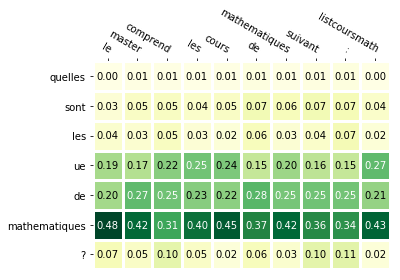

'le master comprend les cours de mathematiques suivant : listcoursmath'

In [27]:
chatbot.eval()
chatbot('quelles sont les ue de mathématiques ?', show_attention = True)

In [ ]:
chatbot.eval()
chatbot('ou je peux trouver la liste des ue de mathématiques ?', show_attention = True)